In [ ]:
!pip install geopandas

In [2]:
import os
import cv2
from random import random
import time
import geopandas as gpd
try:
    from google.colab.patches import cv2_imshow 
except:
    from cv2 import imshow as cv2_imshow

In [3]:
#initialize google earth engine
import ee
try:
  ee.Initialize()
except:
  ee.Authenticate()
  ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=PO6Jh8aLtUdQfeE2Q7O3fGFmTuTbq3sEc-cqurYodcE&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5uHVDHSPeFy9VdwVva6xKZjm12Brgt5ang0xKf1AdTMzCcFIfaDcM

Successfully saved authorization token.


## Helper functions

In [14]:
def loadShapefile(file,debug=False):
  Regions = []

  #load shapefile using geopandas
  loadShapefile = gpd.read_file(file)

  #To avoid 'null' not defined exception
  null = None 

  totalRegionsInShapeFile = loadShapefile.shape[0]
  for row in range(totalRegionsInShapeFile): 
    geo =  loadShapefile.iloc[row:row+1,:]
    jsonDict = eval(geo.to_json())
    geojsonDict = jsonDict['features'][0]
    Regions.append(ee.FeatureCollection(ee.Feature(geojsonDict)).geometry())

  if debug: print("Total sub-regions in the shapefile:",len(Regions))

  return Regions


In [6]:

def applyClassification(img,bands,classifierAlgo,
                        roi,color,landcover_type,save,debug = False):
  
  classifier = img.select(bands).classify(classifierAlgo);


  url = classifier.getThumbURL({
    'region':roi,
    'min': 0, 'max': 2,
    'palette': color,
  })

  date = img.date().format('YYYY-MM-dd').getInfo()
  
  if debug: print('Timestamp: ', date);
  fname = landcover_type+"_"+str(date)+str(random()).split('.')[1]+".png"


  status = os.system(f"""wget -O "{fname}" -c --read-timeout=5 --tries=0 "{url}" """)

  if (not status):
    if debug:
      print("File name:", fname)
      img_class = cv2.imread(fname)
      cv2_imshow(img_class)
    if not save:
      os.remove(fname)
      fname = "NaN"
    

def classifyROI(classifier,roi,
                color,inputs,tuning_parameters,landcover_type,
                save = False,debug = False):
  
  bands = tuning_parameters[landcover_type]


  #filter satellite data
  imageCollection = ee.ImageCollection(tuning_parameters['satellite_ID']) \
          .filterDate(inputs['from_date'], inputs['to_date']) \
          .filterBounds(roi) \
          .filterMetadata('CLOUD_COVER', 'less_than', tuning_parameters['cloud_cover'])

  count = imageCollection.size().getInfo()
  if debug: print("Total satellite images available across the date range:",count)

  #image = ee.Image(imageCollection.toList(imageCollection.size()).get(0)) # 0 -- > get first image
  for idx in range(count):
      print("Processing time period: {0} of {1}".format(idx+1,count))
      image = ee.Image(imageCollection.toList(imageCollection.size()).get(idx))

      #apply classification over the image
      applyClassification(image,bands,classifier,
                          roi,color,landcover_type,save,debug)


## Input Parameters

In [ ]:
!wget "https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_SEN_shp.zip"
!unzip "/content/gadm36_SEN_shp.zip"

In [8]:
tuning_parameters = {
    'satellite_ID' : 'LANDSAT/LC08/C01/T1_TOA',
    'featureCollection': 'GOOGLE/EE/DEMOS/demo_landcover_labels',
    'vegetation' : ['B5', 'B4', 'B3'],
    'water':['B5', 'B6', 'B4'],
    'cloud_cover': 10,
}


inputs = {
    'shapefile' : "/content/gadm36_SEN_3.shp",
    'from_date' : '2020-01-01',
    'to_date' : '2020-03-01',   
}



In [22]:
#Load region of interest from shapefile
regions = loadShapefile(inputs['shapefile'],debug=True)

#Taking one of the sub-regions as region of interest 
roi = regions[12]

Total sub-regions in the shapefile: 123


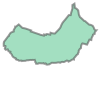

In [23]:
#visualising the shapefile
loadShapefile_sample = gpd.read_file(inputs['shapefile'])
loadShapefile_sample['geometry'][12] #12-->sub region

## Define classifier

In [17]:
class LandcoverClassifier:

  def __init__(self,inputs,tuning_parameters,roi):

    #define region of interest
    self.roi = roi
    
    #select satellite and filter data

    #same satellite ID of feature collected for training
    self.l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1')

    #to apply classifier over the image collection
    self.l8_inference = ee.ImageCollection(tuning_parameters['satellite_ID']) \
        .filterDate(inputs['from_date'], inputs['to_date']) \
        .filterBounds(self.roi) \
        .filterMetadata('CLOUD_COVER', 'less_than', tuning_parameters['cloud_cover'])

    #For training
    self.satellite_data = ee.Algorithms.Landsat.simpleComposite(**{
      'collection': self.l8.filterDate(inputs['from_date'], inputs['to_date']),
      'asFloat': True
    })
    #define feature points
    self.feature_points = ee.FeatureCollection(tuning_parameters['featureCollection'])


  #https://developers.google.com/earth-engine/apidocs/ee-classifier-libsvm?hl=en
  def svmClassifier(self,bands):

    training = self.satellite_data.select(bands).sampleRegions(**{
      "collection": self.feature_points, 
      "properties": ['landcover'], 
      "scale": 30,
      
    })

    svm_classifier = ee.Classifier.libsvm().train(**{
      "features": training, 
      "classProperty": 'landcover', 
      "inputProperties": bands,

    })
    return svm_classifier

  #https://developers.google.com/earth-engine/apidocs/ee-classifier-smilerandomforest?hl=en
  def randomForestClassifier(self,bands):
    training = self.satellite_data.select(bands).sampleRegions(**{
      "collection": self.feature_points, 
      "properties": ['landcover'], 
      "scale": 30,
      
    })

    random_forest_classifier = ee.Classifier.smileRandomForest(2).train(**{
      "features": training, 
      "classProperty": 'landcover', 
      "inputProperties": bands
    })

    return random_forest_classifier

  #https://developers.google.com/earth-engine/apidocs/ee-classifier-smilecart?hl=en#python
  def CARTClassifier(self,bands):
    training = self.satellite_data.select(bands).sampleRegions(**{
        "collection": self.feature_points, 
        "properties": ['landcover'], 
        "scale": 30,
        
      })

    CART_classifier = ee.Classifier.smileCart().train(**{
        "features": training, 
        "classProperty": 'landcover', 
        "inputProperties": bands
      })
    return CART_classifier




In [24]:
#initialize classifier
landCover = LandcoverClassifier(inputs,tuning_parameters,roi)

## Apply SVM classifier

Processing 1 of 2 category
Processing water cover
Total satellite images available across the date range: 2
Processing time period: 1 of 2
Timestamp:  2020-01-06
File name: water_2020-01-0612185598792162688.png


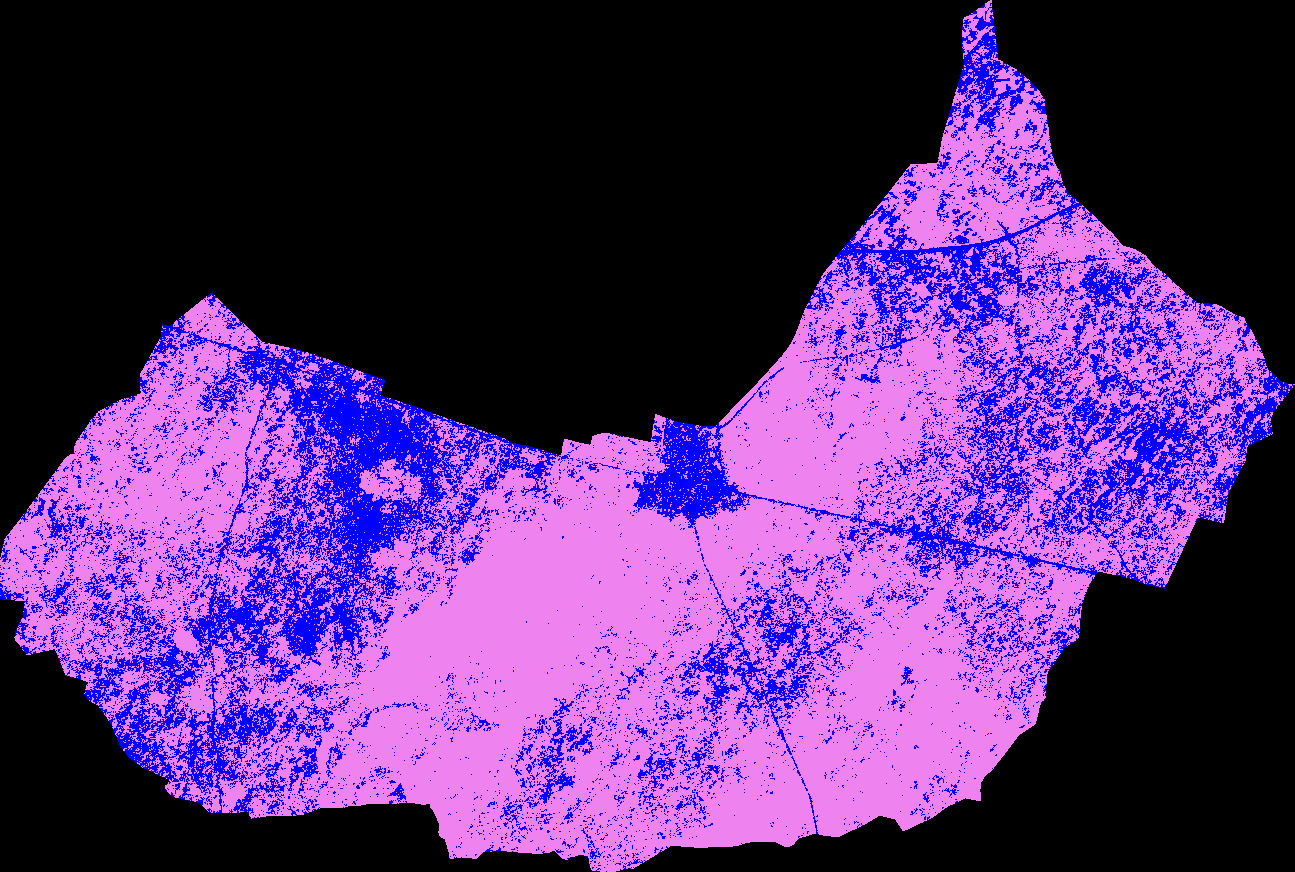

Processing time period: 2 of 2
Timestamp:  2020-02-07
File name: water_2020-02-0724092018844830854.png


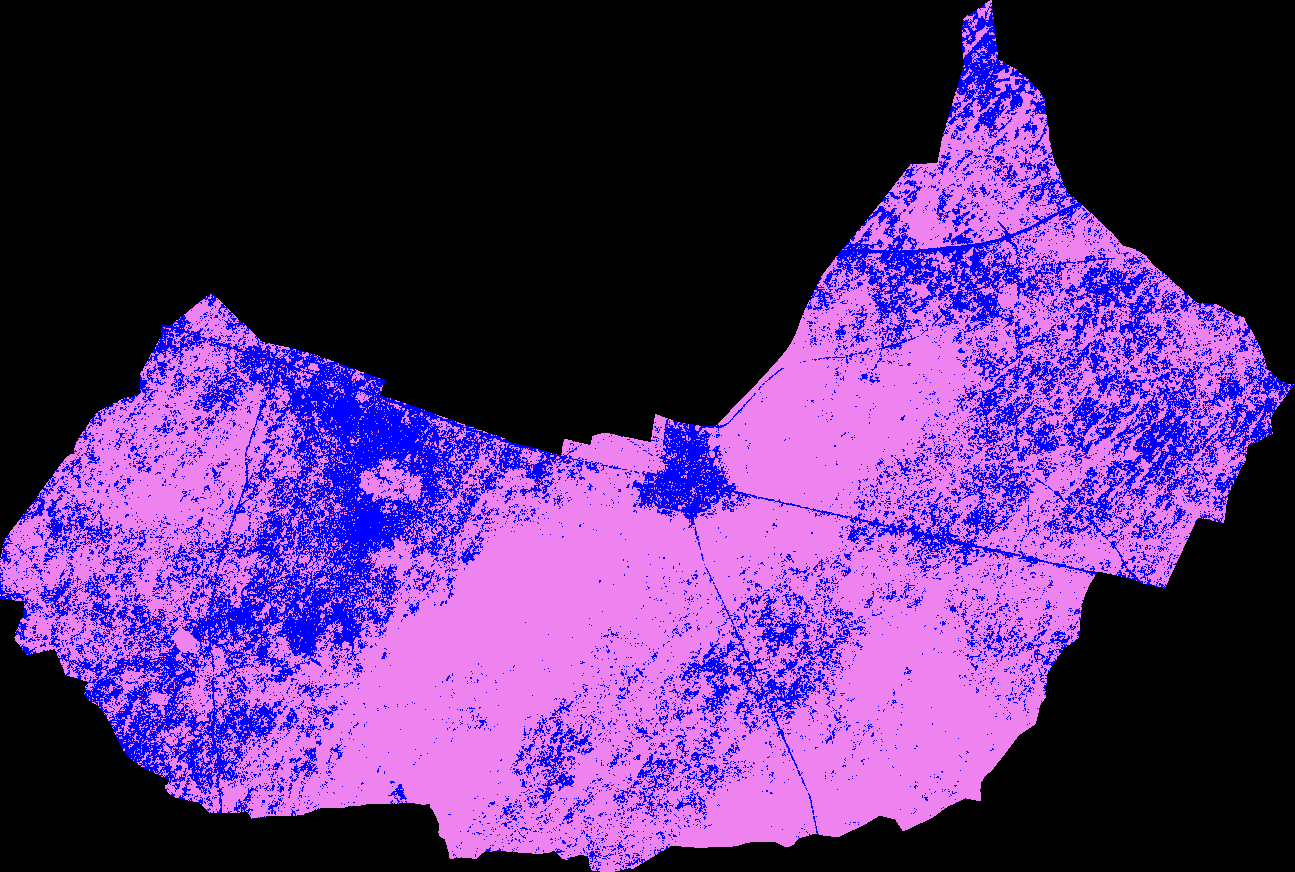

Processing 2 of 2 category
Processing vegetation cover
Total satellite images available across the date range: 2
Processing time period: 1 of 2
Timestamp:  2020-01-06
File name: vegetation_2020-01-067361637505681868.png


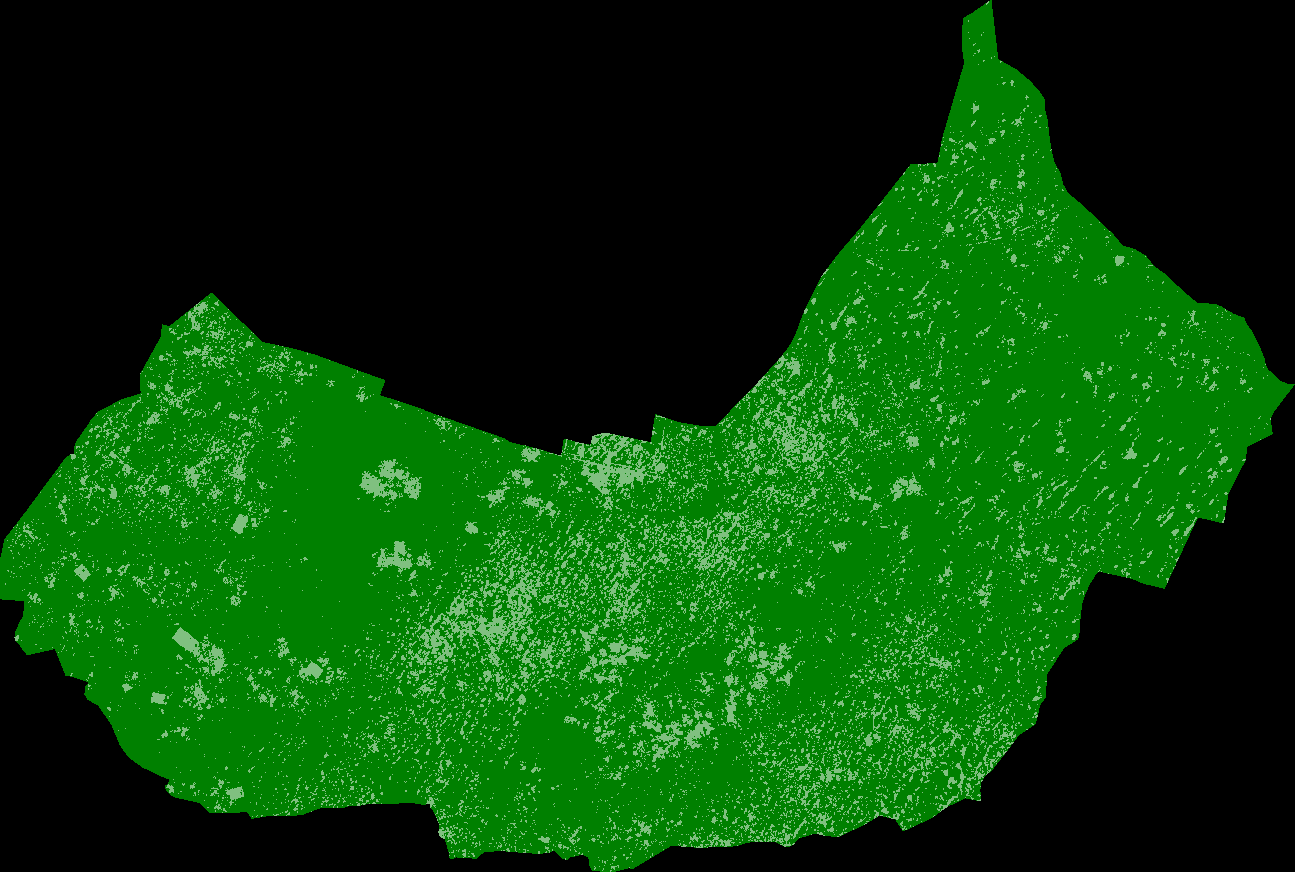

Processing time period: 2 of 2
Timestamp:  2020-02-07
File name: vegetation_2020-02-075635159154563724.png


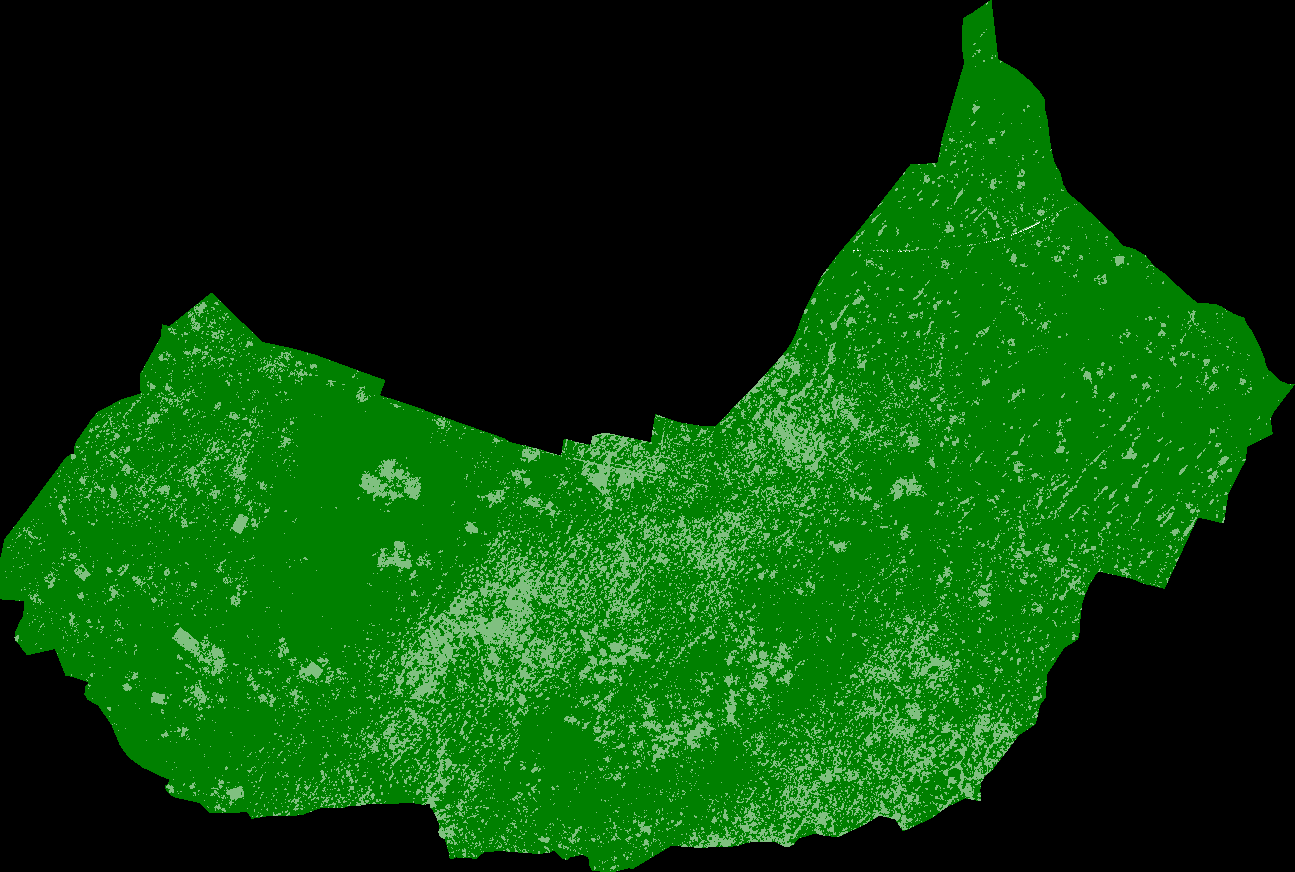

Completed !!


In [25]:
#catagories to classify
landCoverType = ['water','vegetation']
totalCategory = len(landCoverType)

for idx,landcovertype in enumerate(landCoverType):
  print("Processing {0} of {1} category".format(idx+1,totalCategory))
  print("Processing {} cover".format(landcovertype))

  #false color applied to the output for visualizing
  if landcovertype == "vegetation":
    colorMap = ['green','white']
  elif landcovertype == "water":
    colorMap = ['blue','violet','white']
  else:
    print("invalid")
    break

  #select classifier
  Classifier = landCover.svmClassifier(tuning_parameters[landcovertype])
  

  #Process regions            
  classifyROI(Classifier,landCover.roi,
              colorMap,inputs,tuning_parameters,landcovertype,
              save = False,debug = True)
print("Completed !!")

## Apply Random Forest Classifier

Processing 1 of 2 category
Processing water cover
Total satellite images available across the date range: 2
Processing time period: 1 of 2
Timestamp:  2020-01-06
File name: water_2020-01-0611212684852400756.png


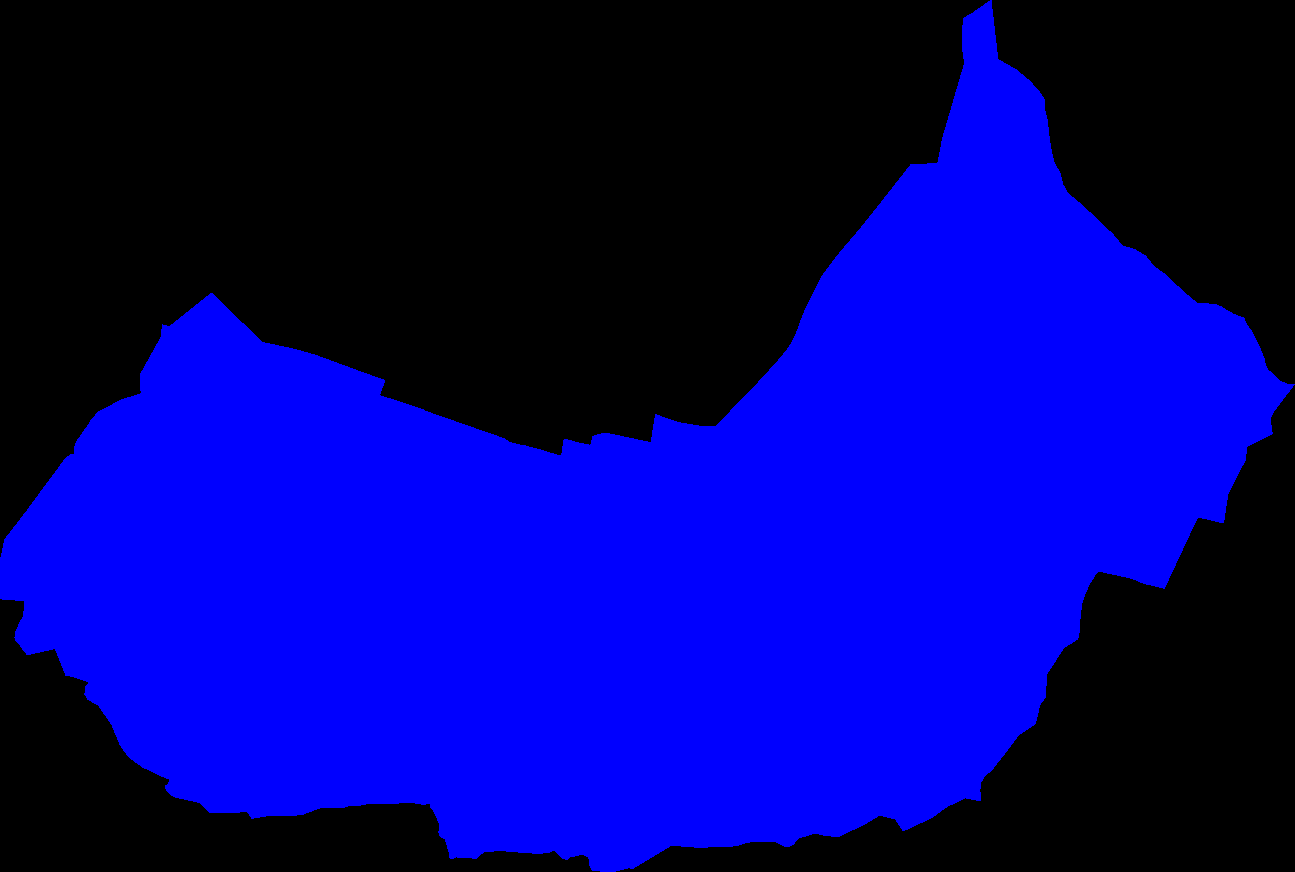

Processing time period: 2 of 2
Timestamp:  2020-02-07
File name: water_2020-02-0738023594000036476.png


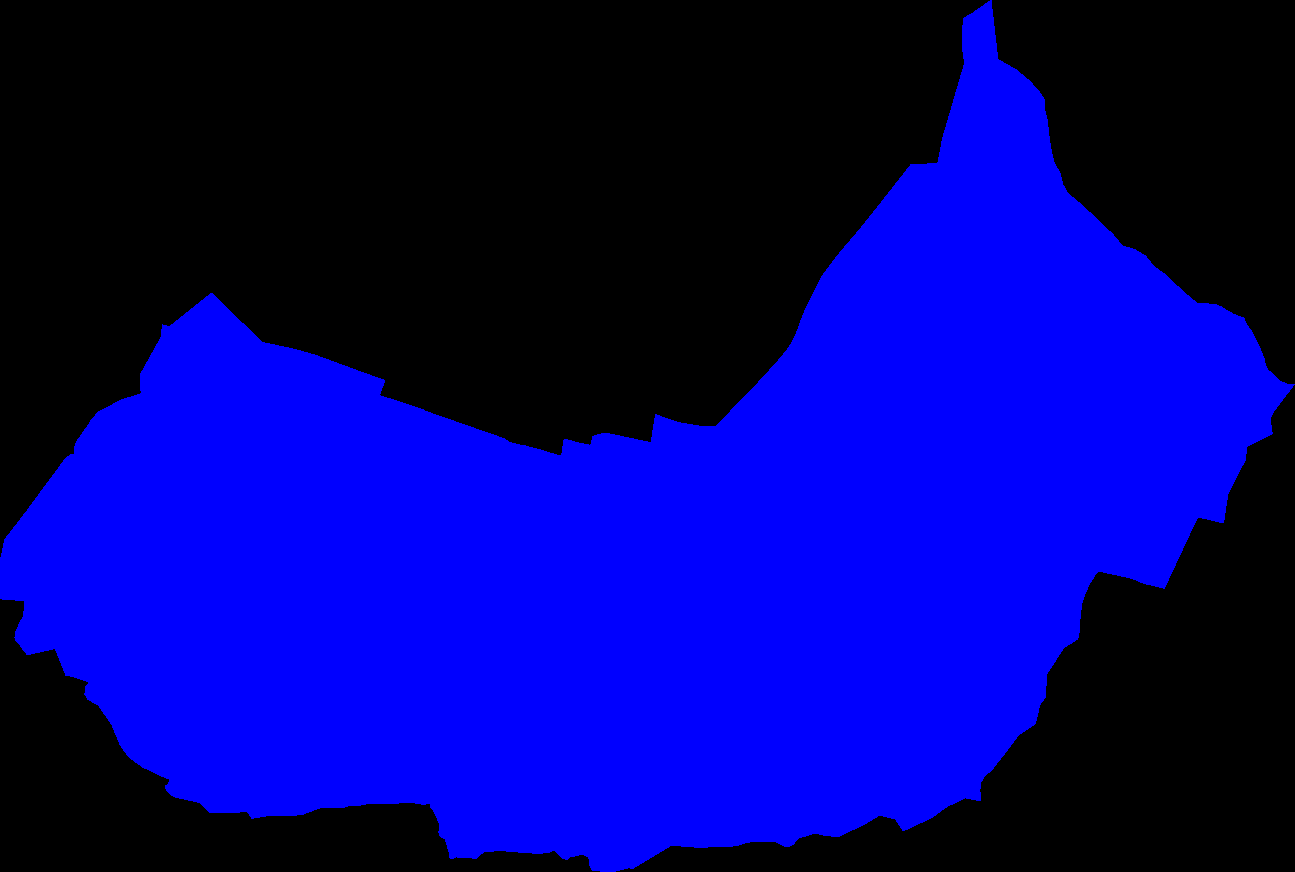

Processing 2 of 2 category
Processing vegetation cover
Total satellite images available across the date range: 2
Processing time period: 1 of 2
Timestamp:  2020-01-06
File name: vegetation_2020-01-064313087183638431.png


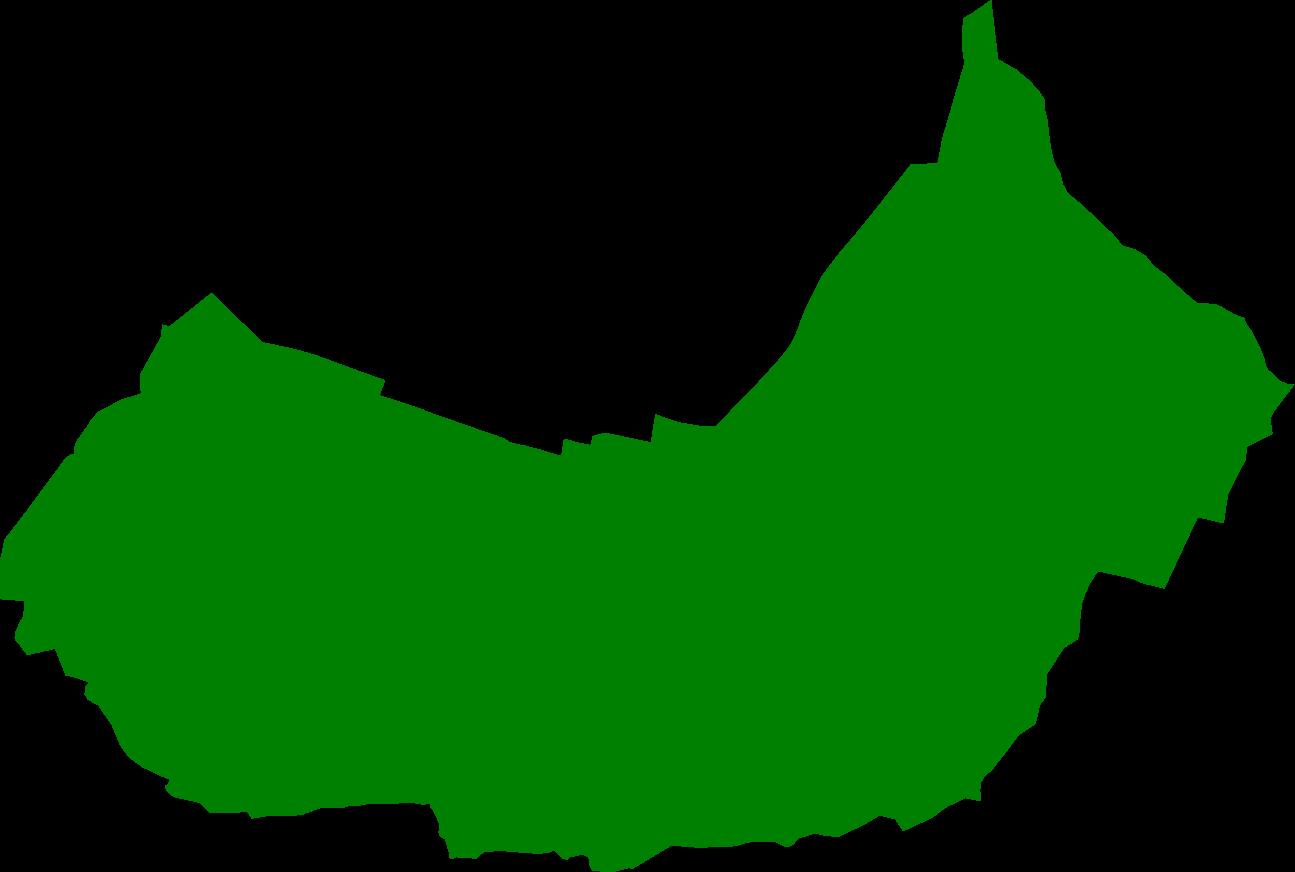

Processing time period: 2 of 2
Timestamp:  2020-02-07
File name: vegetation_2020-02-075957337029415064.png


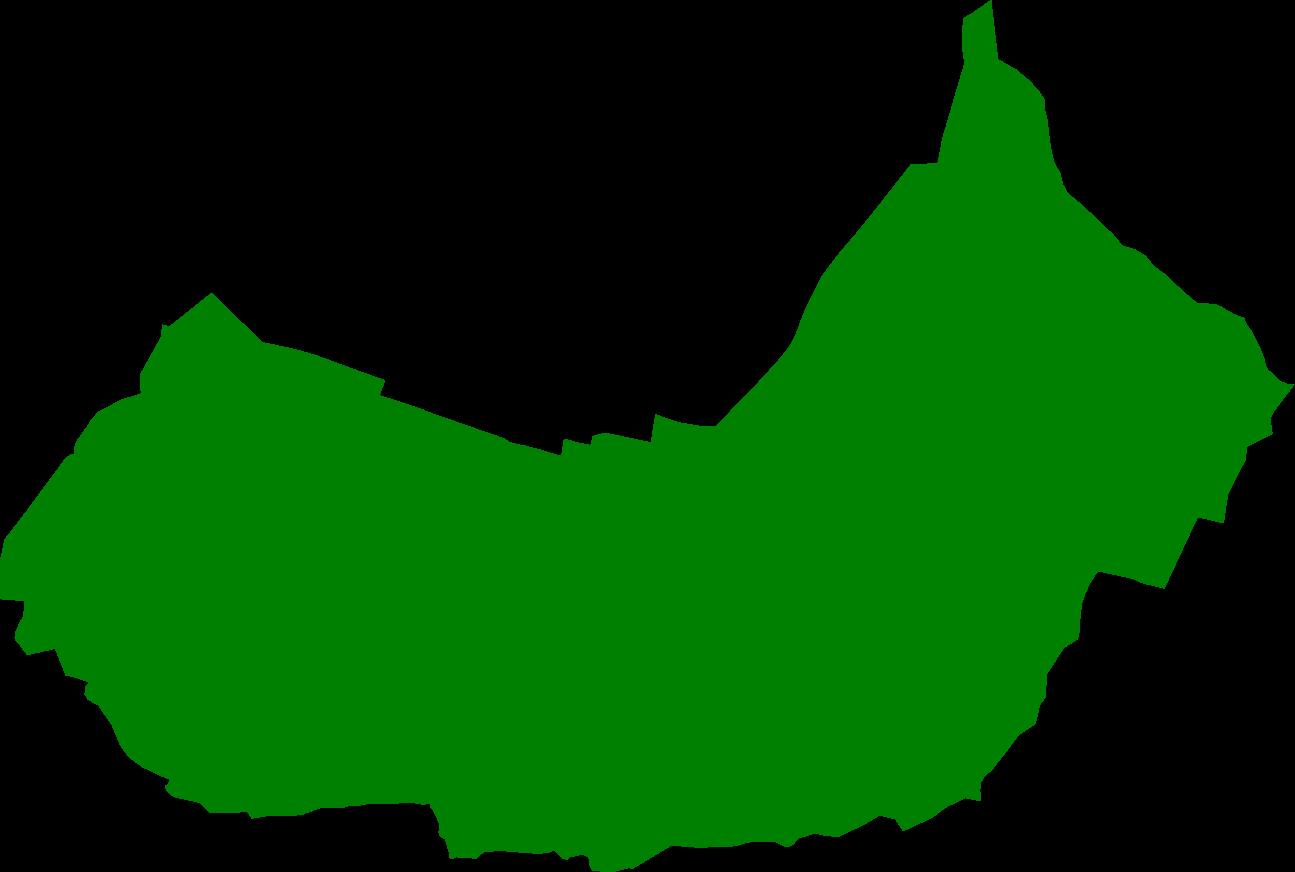

Completed !!


In [26]:
#catagories to classify
landCoverType = ['water','vegetation']
totalCategory = len(landCoverType)

for idx,landcovertype in enumerate(landCoverType):
  print("Processing {0} of {1} category".format(idx+1,totalCategory))
  print("Processing {} cover".format(landcovertype))

  #false color applied to the output for visualizing
  if landcovertype == "vegetation":
    colorMap = ['green','white']
  elif landcovertype == "water":
    colorMap = ['blue','violet','white']
  else:
    print("invalid")
    break

  #select classifier
  Classifier = landCover.randomForestClassifier(tuning_parameters[landcovertype])
  

  #Process regions            
  classifyROI(Classifier,landCover.roi,
              colorMap,inputs,tuning_parameters,landcovertype,
              save = False,debug = True)
print("Completed !!")

## Apply CART Classifier

Processing 1 of 2 category
Processing water cover
Total satellite images available across the date range: 2
Processing time period: 1 of 2
Timestamp:  2020-01-06
File name: water_2020-01-068886838332345758.png


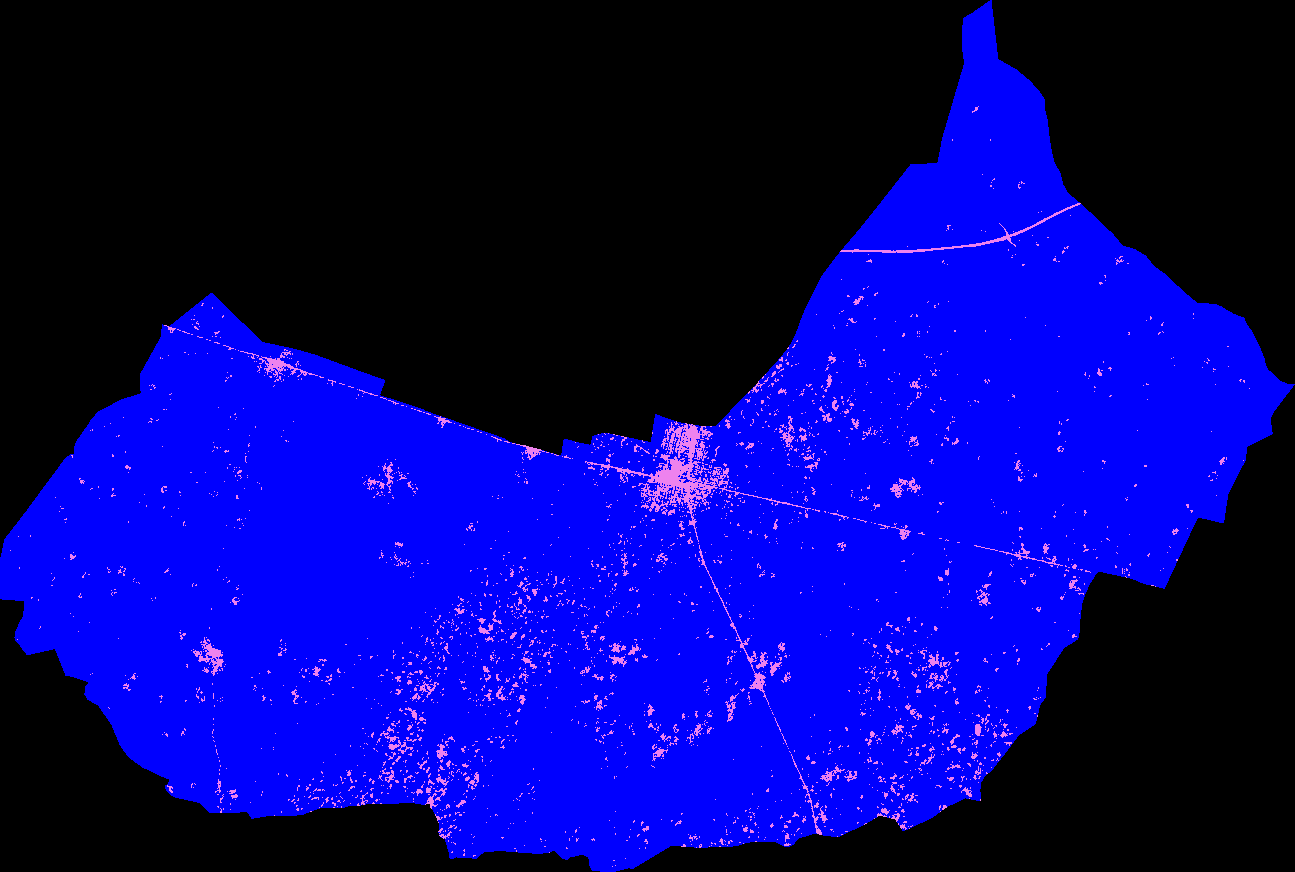

Processing time period: 2 of 2
Timestamp:  2020-02-07
File name: water_2020-02-0718829654885522384.png


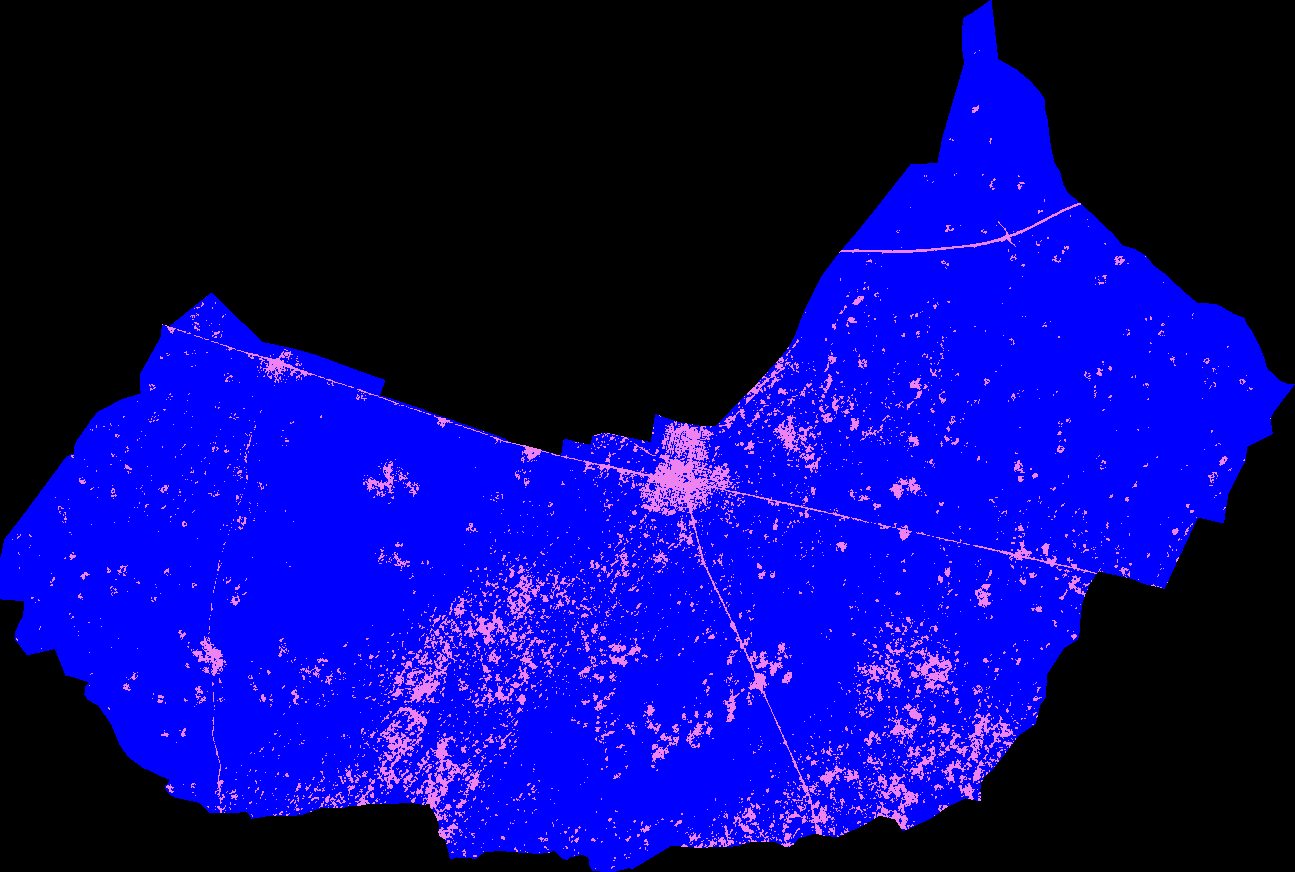

Processing 2 of 2 category
Processing vegetation cover
Total satellite images available across the date range: 2
Processing time period: 1 of 2
Timestamp:  2020-01-06
File name: vegetation_2020-01-06801964022380272.png


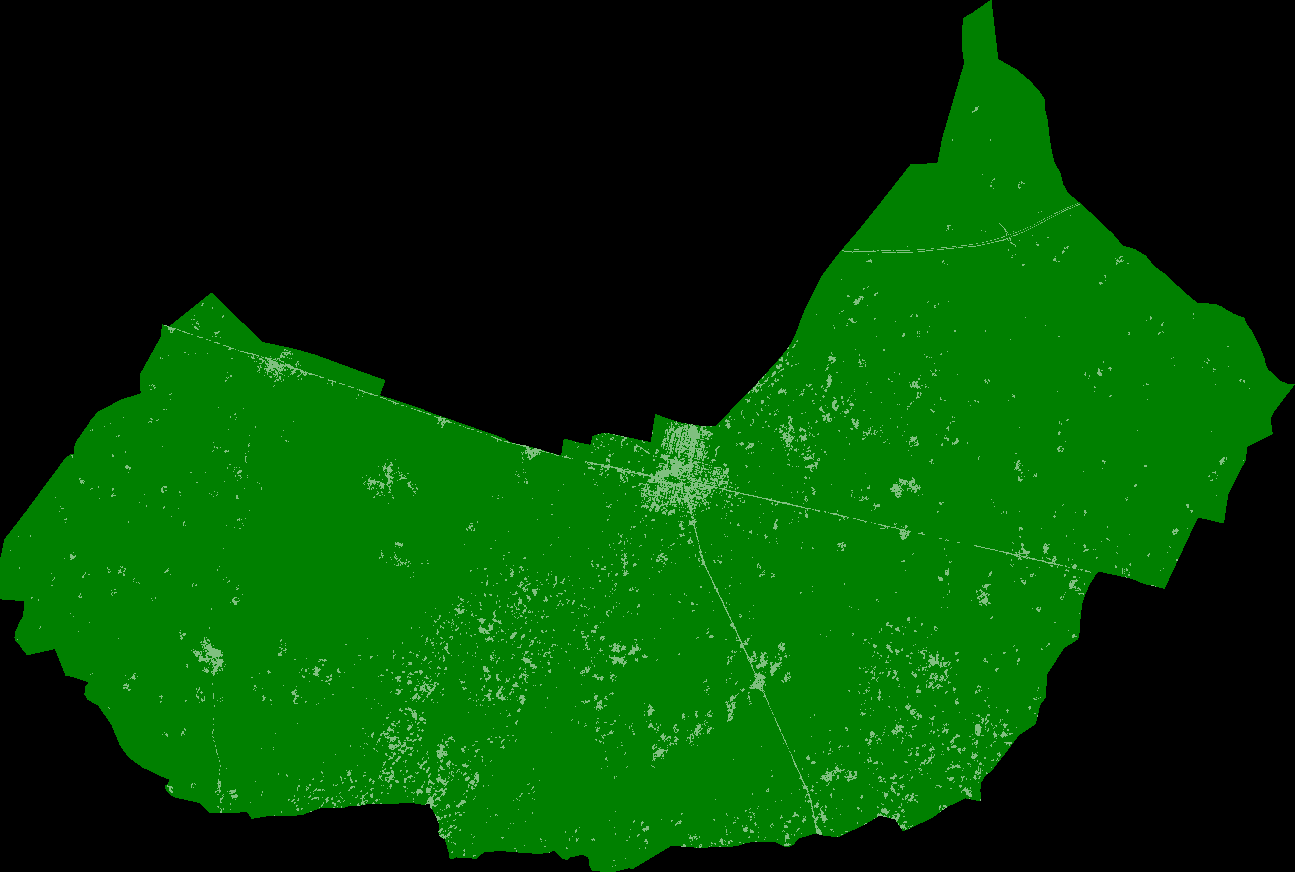

Processing time period: 2 of 2
Timestamp:  2020-02-07
File name: vegetation_2020-02-076093813300805198.png


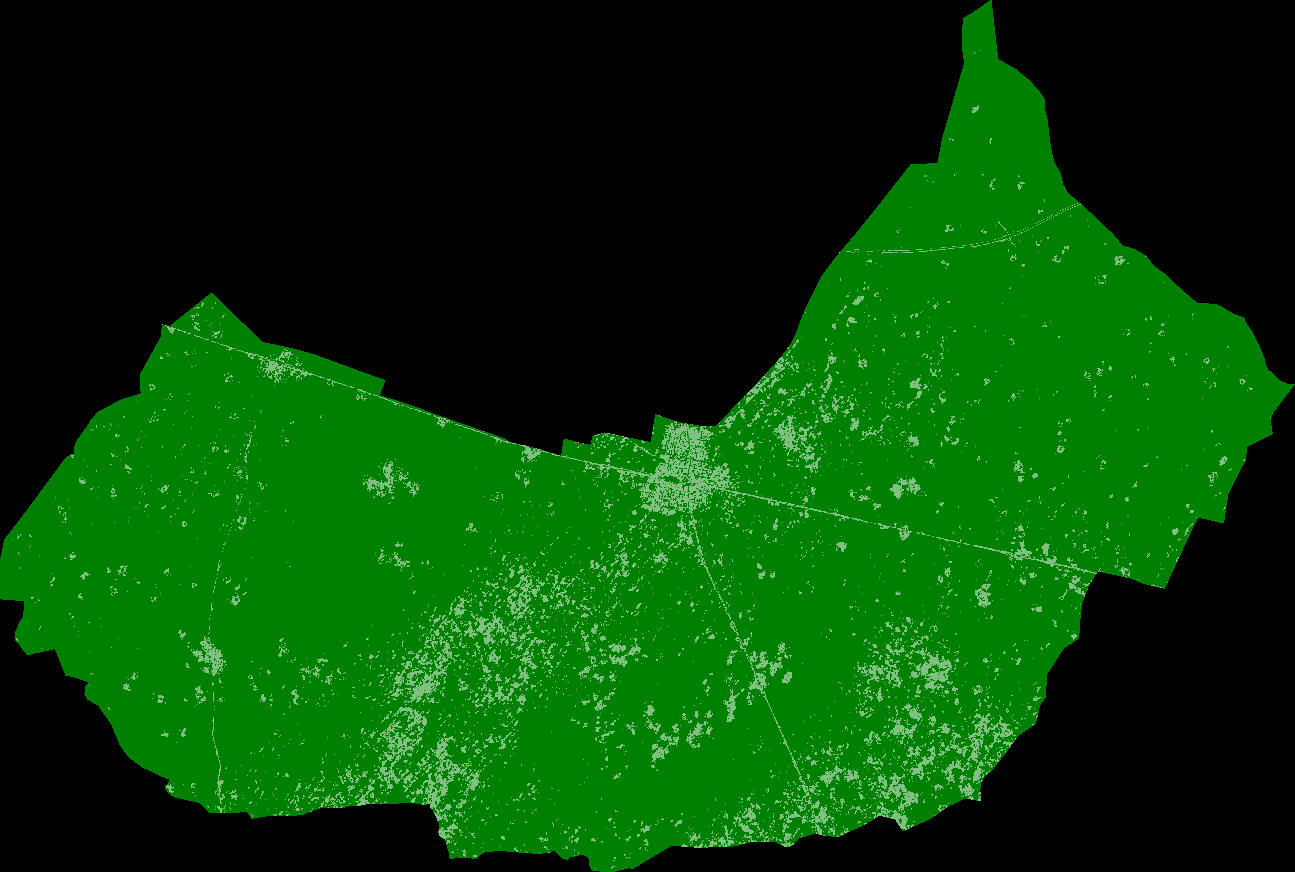

Completed !!


In [27]:
#catagories to classify
landCoverType = ['water','vegetation']
totalCategory = len(landCoverType)

for idx,landcovertype in enumerate(landCoverType):
  print("Processing {0} of {1} category".format(idx+1,totalCategory))
  print("Processing {} cover".format(landcovertype))

  #false color applied to the output for visualizing
  if landcovertype == "vegetation":
    colorMap = ['green','white']
  elif landcovertype == "water":
    colorMap = ['blue','violet','white']
  else:
    print("invalid")
    break

  #select classifier
  Classifier = landCover.CARTClassifier(tuning_parameters[landcovertype])
  

  #Process regions            
  classifyROI(Classifier,landCover.roi,
              colorMap,inputs,tuning_parameters,landcovertype,
              save = False,debug = True)
print("Completed !!")